In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
!nvidia-smi

Wed Sep 20 17:11:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   80C    P0    46W /  70W |   5231MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [44]:
path = '/content/drive/MyDrive/Dataset/'

In [45]:
import tensorflow as tf
from tensorflow.keras import models
import matplotlib.pyplot as plt


In [69]:
IMAGE_SIZE = 500
BATCH_SIZE = 16
CHANNELS = 3
EPOCHS = 500

In [70]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 869 files belonging to 4 classes.


In [71]:
class_names = dataset.class_names
print(dataset.class_names)
print(len(dataset)) #55 data batches

['desert_data', 'hills_data', 'nw_africa_data', 'rainforest_data']
55


In [72]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(16, 500, 500, 3)
[0 1 0 2 0 0 0 0 3 1 2 3 2 2 0 3]


(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)


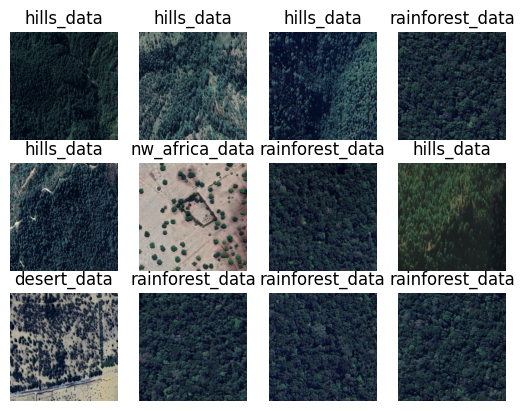

In [73]:
for image_batch, label_batch in dataset.take(1):
    for i in range (12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(class_names[label_batch[i]])
        print(image_batch[i].shape)

In [74]:
train_size = 0.8
test_size = 0.1
val_size = 0.1
len(dataset)*train_size #80 % the data is to be used to train

44.0

In [75]:
train_ds = dataset.take(44)
len(train_ds)

44

In [76]:
test_ds = dataset.skip(44)
len(test_ds)
len(dataset)*val_size

5.5

In [77]:
val_ds = test_ds.take(5)
len(val_ds)

5

In [78]:
test_ds = test_ds.skip(5)
len(test_ds)

6

In [79]:
def get_dataset_partition_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=1000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [80]:
train_ds,val_ds,test_ds = get_dataset_partition_tf(dataset)
print(len(train_ds),len(val_ds),len(test_ds))

44 5 6


In [81]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [82]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [83]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [84]:
#CNN loaded and implemented
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 4
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape=input_shape)

In [85]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (16, 500, 500, 3)         0         
                                                                 
 sequential_8 (Sequential)   (16, 500, 500, 3)         0         
                                                                 
 conv2d_14 (Conv2D)          (16, 498, 498, 32)        896       
                                                                 
 max_pooling2d_14 (MaxPooli  (16, 249, 249, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (16, 247, 247, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPooli  (16, 123, 123, 64)        0         
 ng2D)                                                

In [86]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [87]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/500
44/44 [==============================] - 33s 405ms/step - loss: 0.9222 - accuracy: 0.4820 - val_loss: 0.6955 - val_accuracy: 0.6625
Epoch 2/500
44/44 [==============================] - 5s 111ms/step - loss: 0.7202 - accuracy: 0.5945 - val_loss: 0.6574 - val_accuracy: 0.6250
Epoch 3/500
44/44 [==============================] - 5s 111ms/step - loss: 0.6716 - accuracy: 0.6508 - val_loss: 0.9271 - val_accuracy: 0.5375
Epoch 4/500
44/44 [==============================] - 5s 112ms/step - loss: 0.7102 - accuracy: 0.6378 - val_loss: 0.6470 - val_accuracy: 0.6500
Epoch 5/500
44/44 [==============================] - 5s 111ms/step - loss: 0.6749 - accuracy: 0.6797 - val_loss: 0.6401 - val_accuracy: 0.5875
Epoch 6/500
44/44 [==============================] - 5s 114ms/step - loss: 0.6232 - accuracy: 0.6696 - val_loss: 0.6855 - val_accuracy: 0.6125
Epoch 7/500
44/44 [==============================] - 5s 111ms/step - loss: 0.5594 - accuracy: 0.7403 - val_loss: 0.4075 - val_accuracy: 0.812